In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 16*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh

from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2
from lidar_nerf_utils import *

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-07-27 08:47:39.114826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 08:47:39.794599: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 08:47:41.026764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2024-07-27 08:47:41.026932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7:

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-27 08:47:43.761192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 08:47:43.763097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-27 08:47:43.763416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-27 08:47:43.763674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [3]:
from remove_motion_basic import linear_correction_old as lc

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
sensor_poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
sensor_poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
sensor_poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
sensor_poses = np.einsum("nij,jk->nik", sensor_poses, T_CL)
initial_pose = np.linalg.inv(sensor_poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
sensor_poses = np.einsum("ij,njk->nik", np.linalg.inv(sensor_poses[0]), sensor_poses) #TRY COMMENTING OUT...

#get body frame vel to remove motion disortion from training data
vel_world_frame = np.diff(sensor_poses[:,:3,-1], axis = 0)
vel_body_frame = np.linalg.pinv(sensor_poses[1:,:3,:3]) @ vel_world_frame[:,:,None]
vel_body_frame = vel_body_frame[:,:,0]
#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
window=50
MAx = moving_average(vel_body_frame[:,0], n = window)
MAy = moving_average(vel_body_frame[:,1], n = window)
MAz = moving_average(vel_body_frame[:,2], n = window)
vel_body_frame = np.array([MAx, MAy, MAz]).T

rot_vel_euls = np.diff(R.from_matrix(sensor_poses[:,:3,:3]).as_euler('xyz'), axis = 0)
idx = np.argwhere(rot_vel_euls > (np.pi))
rot_vel_euls[idx] = 0
idx = np.argwhere(rot_vel_euls < (-np.pi))
rot_vel_euls[idx] = 0

pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 5 #10
submap = HD_map[::show_nth]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# #LOAD [-15,17.5]x1000, @0.005
# np.save("/home/derm/Desktop/posesEval.npy", poses)
# np.save("/home/derm/Desktop/imagesEval.npy", images)
poses = np.load("/home/derm/Desktop/poses.npy") # <--- used these for best NeRF training
images = np.load("/home/derm/Desktop/images.npy")
# poses = np.load("/home/derm/Desktop/posesEval.npy") # <--- every 5th frame, [7700:8800] for benchmarking
# images = np.load("/home/derm/Desktop/imagesEval.npy")
#LOAD [-17.5,15]x1000, @0.005
# np.save("/home/derm/Desktop/posesM17P15.npy", poses)
# np.save("/home/derm/Desktop/imagesM17P15.npy", images)
# poses = np.load("/home/derm/Desktop/posesM17P15.npy")
# images = np.load("/home/derm/Desktop/imagesM17P15.npy")

#LOAD [-15,17]x1000, 8x8 @ 0.005
# np.save("/home/derm/Desktop/poses8x8.npy", poses)
# np.save("/home/derm/Desktop/images8x8.npy", images)

# #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
# rotm[:3,-1] *= 0.002 #0.005 #0.02 #0.05
# images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.002 #0.005 #0.02 #0.005 #0.05
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

(64, 0)


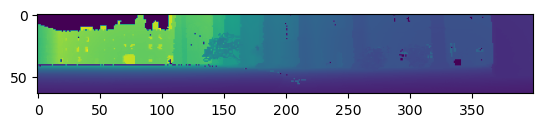

In [4]:
temp = np.zeros([np.shape(images)[1],0])
print(np.shape(temp))
for img_i in range(0,50):
    temp = np.append(temp,images[img_i,:,:,0], axis = 1)

fig, ax = p.subplots()
ax.imshow(temp)

# # # #get some window in our test
testimg = images[12]
testpose = poses[12]

# Train NeRF using old single-network strategy

z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)


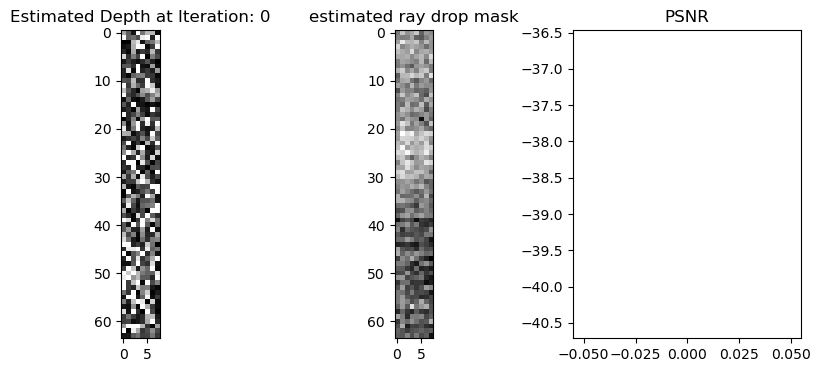

z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: tf.Tensor([ 64   8 128   1], shape=(4,), dtype=int32)
z_vals: 

KeyboardInterrupt: 

In [1309]:
from lidar_nerf_utils import *
from numpy.lib.stride_tricks import sliding_window_view

model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
# optimizer = tf.keras.optimizers.Adam(5e-5) #anneal to this (LiDAR NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-5)
# optimizer = tf.keras.optimizers.Adam(5e-6) #anneal to this (Mip-NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-6) #TEST

N_samples = 128 #128
near=0.
far=1.
N_iters = 5_000_000
psnrs = []
iternums = []
i_plot = 64
accumulate_gradients_steps = 1 #32
runfine = True
# runfine = False

#IMPORTANT-- this needs to match values used when setting up training data 
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

phimin = np.deg2rad(-15.594) #observed in raw data 
phimax = np.deg2rad(17.743) #observed in raw data

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

gradients = [tf.zeros_like(var) for var in model.trainable_variables]
accumulated_loss = 0.0

for i in range(N_iters+1):
#     print(i)
    img_i = np.random.randint(images.shape[0])
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]

    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]

    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
#         z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = True)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        loss_coarse = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF) #punish similar depth returns
        loss = loss_coarse
        
        print("z_vals:", tf.shape(z_vals))
        
        if runfine:
            # run through a 2nd time network ~~~~~~~~~~~~~~~~~~
            #pad weights with zeros
#             fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#             rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#             #use additional axis to calculate all at once
#             fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#             rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
            #TEST-- slightly wider blur-pool
            fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
            rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
            fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
            rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)

    
            #blur-pool as vectorized operation
            test2 = (fwd_test + rev_test) /2 #blur
    #         test2 += 1/N_samples #shift up slightly
            test2 += 1/(3*N_samples) #shift up slightly
            test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
            
            cum_hist_vals = np.cumsum(test2, axis = -1)
            cum_hist_vals_flat = cum_hist_vals.flatten()
    
            #modify cum_hist_vals so it is monotonically increasing (needed for interp func to work)
            step_corr = np.linspace(0,W*H-1,W*H)
            step_corr = np.tile(step_corr,(N_samples,1)).T
            step_corr = np.reshape(step_corr, [1,-1])[0,:]
            cum_hist_vals_flat+= step_corr
    
            linear_spaced = np.linspace(near, H*W, N_samples*H*W)
#             #fix spacing-- go all the way through [min, max] on every channel???
#             linear_spaced = np.linspace(near, far, N_samples)
#             linear_spaced = np.tile(linear_spaced, (H*W))
#             linear_spaced += step_corr

            ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
            ans -= step_corr
            ans *= far #scale back to max value
#             ans = np.abs(ans) #old-- was shifted to the left
            ans = np.abs(ans) + 1/N_samples #took forever to figure this one out...
            z_vals = np.reshape(ans, [H,W,N_samples,1])
            
            gtCDF = z_vals[:,:,:,0] > target[:,:,:]
            gtCDF = tf.cast(gtCDF, tf.float32)
            
            #run actual 2nd pass through same network
            depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
            depth = depth[:,:,None]
            depth = tf.cast(depth, tf.float32) #why do I have to cast this here???
            ray_drop = ray_drop[:,:,None]
            
            # loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask)
            loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
            loss = 0.1*loss_coarse + 0.9*loss_fine 
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
        
        #NEW--prevent NaN gradients from crashing training routine(?) -- needed for monotonically increasing outputs?
        current_gradients = tape.gradient(loss, model.trainable_variables)
        current_gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(current_gradients, model.trainable_variables)]
        gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]        

        # #OLD-- not working with CDF stuff
        # current_gradients = tape.gradient(loss, model.trainable_variables)
        # gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]    
        
        accumulated_loss += loss
    
    if i%accumulate_gradients_steps==0:    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accumulated_loss = 0.0
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]
        accumulated_loss = 0
    
    if i%i_plot==0:
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
#         depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
#         depth, acc, ray_drop, weights, d1, d2 = render_rays(model, rays_o, rays_d,  z_vals)
        # depth, ray_drop, CDF = render_rays(model, rays_o, rays_d,  z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        # loss = calculate_loss(depth, ray_drop, target, target_drop_mask)
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
#         p.imshow(testimg[:,:,1],cmap = "gray") #, norm='log')
#         p.title(f'Actual Mask at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        #look at depth map
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

# Infer cloud at novel frame

In [11]:
num_view = 128 #128 #number of (rotational?) patches to draw
N_samples = 256 #128 #2048 #does not have to match what was used in training
near=0.
far= 1. #0.25 #2.
n_rots = 128 #128 #number |of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
phimin = np.deg2rad(-15.593) #observed in raw data
phimax = np.deg2rad(17.743)
# phimin = np.deg2rad(-17.743) #TEST
# phimax = np.deg2rad(15.593) #TEST
# phimin = np.deg2rad(-16) #TEST
# phimax = np.deg2rad(16) #TEST
# phimin = np.deg2rad(-5) #test -- trying flipped sign first
# phimax = np.deg2rad(25)  #test

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save poitn cloud to external file

very_beginning = time.time()

for j in range(num_view):
# for j in range(12,116):
    before = time.time()
    #get sensor transformation matrix
    rotm = np.eye(4)

    # account for image crop in rotation -------------------
    crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots)
    rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

#     #need to account for the fact that the LIDAR beam isn't actually centered at horizon
#     sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
#     rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
    # ------------------------------------------------------

    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
#     #main courtyard
#     rotm[2,-1] = 0.325  #x in world frame output
#     rotm[0,-1] = 0.008 #z in world frame output
#     rotm[1,-1] = 0.325  #y in world frame
    rotm[2,-1] = 0.45  #x in world frame output
    rotm[0,-1] = 0.01 #z in world frame output
    rotm[1,-1] = 0.40  #y in world frame
#     rotm[2,-1] = 0.2656  #x in world frame output     #starting orientation
#     rotm[0,-1] = 0.006 #0.0086 #z in world frame output
#     rotm[1,-1] = 0.3254  #y in world frame
# #     #forest
#     rotm[2,-1] = 0.299  #x in world frame output
#     rotm[0,-1] = 0.012 #z in world frame output
#     rotm[1,-1] = 0.365  #y in world frame

    rotm = rotm.astype(np.float32)
    
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
#     print(phimin_patch, phimax_patch)
    
    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
#     depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
    z_vals = tf.linspace(near, far, N_samples) 
    z_vals += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals = z_vals[:,:,:,None]
    
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
    elapsed = time.time() - before
#     print("1 forward pass took ", elapsed, "s")
    begin_other = time.time()
    
    #~~~~~~~~~~~
    #run fine pass through network
    fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
    rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
    fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
    rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
#     fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
#     rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
#     fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
#     rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)
    test2 = (fwd_test + rev_test) /2 #blur
    test2 += 1/(3*N_samples) #shift up slightly
    test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
    cum_hist_vals = np.cumsum(test2, axis = -1)
    randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
    cum_hist_vals_flat = cum_hist_vals.flatten()
    step_corr = np.linspace(0,W*H-1,W*H)
    step_corr = np.tile(step_corr,(N_samples,1)).T
    step_corr = np.reshape(step_corr, [1,-1])[0,:]
    cum_hist_vals_flat+= step_corr
    linear_spaced = np.linspace(near, H*W, N_samples*H*W)
    #fix spacing-- go all the way through [min, max] on every channel???
#     linear_spaced = np.linspace(near, far, N_samples)
#     linear_spaced = np.tile(linear_spaced, (H*W))
#     linear_spaced += step_corr
    ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
#     print(ans)
    ans -= step_corr
    ans *= far
    ans = np.abs(ans) + 1/N_samples #took forever to figure this one out...
    z_vals = np.reshape(ans, [H,W,N_samples,1])
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False
                                               )
    #~~~~~~~~~~~
        
    #TEST---- run through again??
    ##TODO-- issue is in using <linear_spaced> a 2nd time since z_vals fed in are not uniform anymore
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    #scale back up to normal size
    depth *= 200 #200 #50 #200
    ray_drop = tf.transpose(ray_drop).numpy() #test
    ray_drop = np.flip(ray_drop, axis = 0) #test
    
    count = 0
    for w in range(W):
        for h in range(H):
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
            if ray_drop[w,h] > 0.9:             
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(np.shape(images)[1] - 1)) #[17.74,-15.59] #(correct)       
            count+= 1

    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) + np.pi #test
    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
#     new_point_cloud_cart[:,1] = -new_point_cloud_cart[:,1] #flip another axis to get back to LHCS (synthetic data only?)

    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
#     # rainbow by z height
#     zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
#     cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
#     disp.append(Points(new_point_cloud_cart, c = cname, r = 2, alpha = 0.5))
    savepc = np.append(savepc, new_point_cloud_cart, axis = 0)
#     print("took ", time.time() - begin_other, "s to do the rest")

#get rid of points at origin
d = np.sqrt(np.sum(savepc**2, axis = 1))
print(np.shape(d))
good  = np.argwhere(d > 1)[:,0]
savepc = savepc[good]


print("took: ", time.time() - very_beginning,"s overall")
# print(testpose)
# print("\n", rotm)
plt.show(disp, "CDF with L1+L2 Loss, train on 64x8 patches, mask oblique surfaces")
ViewInteractiveWidget(plt.window)

(65536,)
took:  11.426483154296875 s overall


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Test creating arbitrary bins for coarse and fine network outputs

In [1926]:
n_bins_coarse = 5
bins_coarse = np.linspace(0,1,n_bins_coarse)
w_coarse = np.gradient(bins_coarse)
# bins_coarse = bins_coarse+w_coarse/2
w_coarse[-1] = 0
vals_coarse = abs(1/(0.6 - bins_coarse))
vals_coarse = vals_coarse/np.sum(vals_coarse)

n_bins_fine = 30
bins_fine = np.linspace(0,1,n_bins_fine)**0.5
# bins_fine = np.sin(np.linspace(0,1,n_bins_fine))
vals_fine = abs(1/((0.6 - bins_fine)*(0.9 - bins_fine)))
w_fine = np.diff(bins_fine)
w_fine = np.append(w_fine, 0)
# bins_fine = bins_fine+w_fine/2
vals_fine = vals_fine/np.sum(vals_fine)

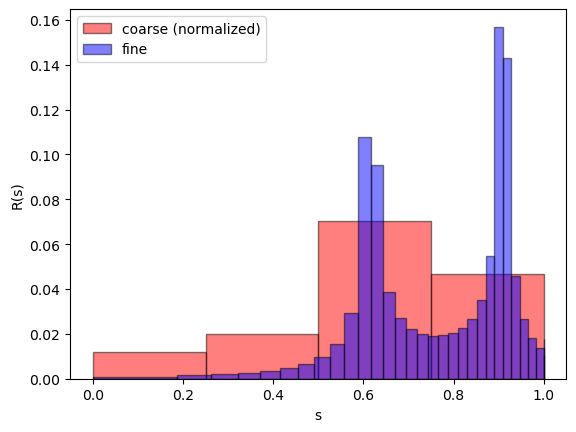

In [1927]:
from matplotlib import pyplot as p
fig, ax = p.subplots()

ax.bar(bins_coarse+w_coarse/2, vals_coarse * (n_bins_coarse/n_bins_fine), width = w_coarse, 
       color ='red', edgecolor = 'black', label = "coarse (normalized)", alpha = 0.5);
# ax.scatter(bins_coarse, np.zeros(len(bins_coarse)), color = 'red')
ax.bar(bins_fine+w_fine/2, vals_fine, width = w_fine, color = 'blue', 
       label = "fine", edgecolor = 'black', alpha = 0.5);
# ax.scatter(bins_fine, np.zeros(len(bins_fine)), color = 'blue')

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper left")

In [1928]:
#Calculate loss for a given region in the coarse histogram
# print(bins_coarse)
# print(bins_fine)
# print(np.sum(vals_coarse), np.sum(vals_fine))

L = np.zeros(len(bins_coarse))
for i in range(len(bins_coarse) - 1):
    #get sample locations in fine distribution that fall within bin i of coarse distribution
    small_enough_idx = np.where(bins_fine < bins_coarse[i+1])
    big_enough_idx = np.where(bins_fine >= bins_coarse[i])
    idx_in_range = np.intersect1d(small_enough_idx, big_enough_idx)

    fine_in_bin = np.sum(vals_fine[idx_in_range])
#     print("\n coarse at i: ", vals_coarse[i])
#     print("fine at i:", fine_in_bin)
  
    L[i] = max(0, fine_in_bin -  vals_coarse[i])
    print("L[i]", L[i])
print(np.sum(L))

L[i] 0.0
L[i] 0.0
L[i] 0.0
L[i] 0.3017487424293642
0.3017487424293642


# Recreating the above process in parallel using tensorflow

In [2547]:
import tensorflow_probability as tfp
#make arbitrary fine distributions (what the fine netork of the scene)
#  these vary in inferred density as well as sampling location
H = 8
W = 2
n_bins_fine = 128
n_bins_coarse = 8

#create random sinusoidal peaks
randy = np.pi*tf.random.uniform([H,W, 2])
# print(np.shape(randy))
lin = tf.cast(tf.linspace(0,1,n_bins_fine), tf.float32)
lin = tf.tile(lin[None,None,:,None], [H,W,1,1])
weights_fine = (tf.math.sin(randy[...,:1,None]*np.pi*lin + randy[...,1:2,None]) +1)/2
weights_fine = weights_fine/tf.math.reduce_sum(weights_fine, axis = 2)[:,:,:,None] #normalize to sum to 1

z_vals_coarse = tf.cast(tf.linspace(0,1,n_bins_coarse), tf.float32)
z_vals_coarse = tf.tile(z_vals_coarse[None,None,:,None], [H,W,1,1])
# print(np.shape(z_vals_coarse))
weights_coarse = (tf.math.sin(randy[...,:1,None]*np.pi*z_vals_coarse + randy[...,1:2,None]) +1)/2
weights_coarse = weights_coarse/tf.math.reduce_sum(weights_coarse, axis = 2)[:,:,:,None] #normalize to sum to 1

w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_coarse = tf.pad(w_coarse, padding_config, constant_values=0.001)


#init z_vals [h, w, n_samples, 1]
#create inconsistant spacing for z vals in fine rays
randy2 = np.pi*tf.cast(tf.random.uniform([H,W, 2]),tf.float32) 
# randy2 = 1-randy
#same as "bins_fine" in previous
z_vals_fine = (tf.math.sin(np.pi*randy2[...,:1,None]*lin + randy2[...,1:,None]) + 2 ) /3
# z_vals = (tf.math.sin(np.pi*randy2[:,:1]*lin + randy2[:,1:]) + 1 ) /2
z_vals_fine = tf.cumsum(z_vals_fine, axis = -2)
# print("z_vals", np.shape(z_vals))
z_vals_fine -= z_vals_fine[:,:,:1,:]
z_vals_fine /= z_vals_fine[:,:,-1:,:]
# print("test", np.shape(z_vals_fine[:,:,-1:,:]))
# print(z_vals[0,0,:,0])

w_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_fine = tf.pad(w_fine, padding_config)
# print(np.shape(w_fine))

L_i: -0.19924834
L_along_ray tf.Tensor(
[-0.18692824 -0.         -0.         -0.         -0.         -0.
 -0.0123201  -0.        ], shape=(8,), dtype=float32)


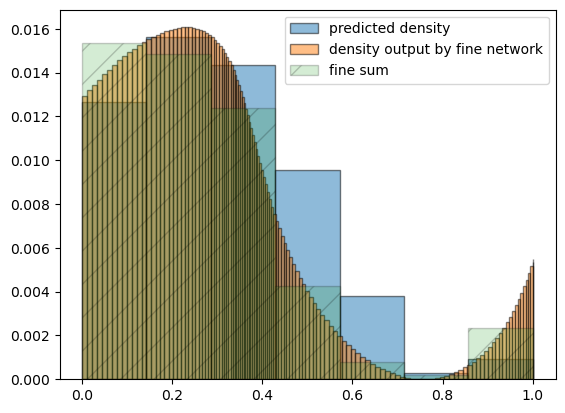

In [2548]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~
#TODO-- get area under curve, not just sum of weights!!!

zc = z_vals_coarse[0,0,:,0]
zf = z_vals_fine[0,0,:,0]
#get index of which bin in coarse each bar in fine belongs inside of
indices = tf.searchsorted(zc, zf, side='right')-1

# Old-- just look at bar heights (not quite right)
# fine_sum = tf.math.segment_sum(weights_fine[0,0,:,0], indices) 

#New-- scale by bar widths
# fine_sum = tf.math.segment_sum(weights_fine[0,0,:,0]*w_fine[0,0,:,0], indices) 
# fine_sum *= (n_bins_coarse-1)/n_bins_coarse
# fine_sum = fine_sum/w_coarse[0,0,:,0]
# fine_sum /= np.sum(fine_sum)
# fine_sum *= (n_bins_coarse-1)/(n_bins_fine-1)
fine_sum = tf.math.segment_sum(weights_fine[0,0,:,0]*w_fine[0,0,:,0], indices)/w_coarse[0,0,:,0]
# print(w_coarse)
# print(fine_sum)

mask = tf.cast(fine_sum > weights_coarse[0,0,:,0]* (n_bins_coarse/n_bins_fine), tf.float32)
L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[0,0,:,0])))
L_along_ray = mask*(fine_sum-weights_coarse[0,0,:,0])
# print(L_along_ray)
print("L_i:", L_i.numpy())
print("L_along_ray", L_along_ray)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, ax = p.subplots()

# ax.scatter(z_vals_fine[0,0,:,0],  tf.ones(np.shape(z_vals_fine)[2]))
# ax.scatter(z_vals_fine[0,0,:,0],  weights_fine[0,0,:,0])
# ax.scatter(z_vals_coarse[0,0,:,0],  weights_coarse[0,0,:,0] *  (n_bins_coarse/n_bins_fine) )
#     ax.scatter(z_vals_fine[0,j,:,0],  weights_fine[0,j,:,0])
#     ax.plot(z_vals_fine[0,j,:,0],  weights_fine[0,j,:,0])
ax.bar(z_vals_coarse[0,j,:,0]+w_coarse[0,j,:,0]/2, weights_coarse[0,j,:,0]* (n_bins_coarse/n_bins_fine), width = w_coarse[0,j,:,0], 
   label = "predicted density", edgecolor = 'black', alpha = 0.5);
# ax.bar(z_vals_coarse[0,j,:,0]+w_coarse[0,j,:,0]/2, weights_coarse[0,j,:,0], width = w_coarse[0,j,:,0], 
#    label = "coarse (scaled)", edgecolor = 'black', alpha = 0.5);
ax.bar(z_vals_fine[0,0,:,0]+w_fine[0,0,:,0]/2, weights_fine[0,0,:,0], width = w_fine[0,j,:,0], 
   label = "density output by fine network", edgecolor = 'black', alpha = 0.5);
ax.bar(z_vals_coarse[0,0,:,0]+w_coarse[0,0,:,0]/2, fine_sum, width = w_coarse[0,j,:,0], 
   label = "fine sum", edgecolor = 'black', hatch = '/', alpha = 0.2);

# #stacked bar chart for loss
# ax.bar(z_vals_coarse[0,0,:,0]+w_coarse[0,0,:,0]/2, -L_along_ray * (n_bins_coarse/n_bins_fine),
#        width = w_coarse[0,0,:,0], bottom = weights_coarse[0,0,:,0] * (n_bins_coarse/n_bins_fine),
#        label = "loss", color = 'red', edgecolor = 'black', hatch = '//', alpha = 0.2);


ax.legend()
# print("fine_sum", fine_sum)
# print(fine_sum > weights_coarse[0,0,:,0])

In [2549]:
def calculate_loss_coarse_network(z_vals_coarse, z_vals_fine, weights_coarse, weights_fine):
    '''Calculate loss for coarse network. Given histograms for scene density outptut by fine network,
    see how close the density estimated by the coarse network got us.'''
    
    def run_on_ray(index): 
        i, j = index
        zc = z_vals_coarse[i, j]
        zf = z_vals_fine[i, j]
        wc = weights_coarse[i, j]
        wf = weights_fine[i, j]
        width_fine_for_ray = width_fine[i,j] 
        width_coarse_for_ray = width_coarse[i,j]
        
        # Get index of which bin in coarse each bar in fine belongs inside of
        idx = tf.searchsorted(zc, zf, side='right') - 1
        # weight "weights" by bar width and sum within each coarse bin
#         print(tf.math.segment_sum(wf*width_fine_for_ray, idx))
#         print(width_coarse_for_ray)
        fine_sum = tf.math.segment_sum(wf*width_fine_for_ray, idx)/width_coarse_for_ray
#         print("fine_sum",fine_sum)

        mask = tf.cast(fine_sum > wc * (n_bins_coarse/n_bins_fine) , tf.float32)
        L_i = tf.math.reduce_sum(mask*(fine_sum-wc))
        return L_i
    
    #get spacing between subsequent z measurements in z_vals_fine to weight contributions
    width_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
#     print(np.shape(width_fine))
    padding_config = [[0, 0],[0, 0],[0, 1]]
    width_fine = tf.pad(width_fine, padding_config)
#     print(np.shape(width_fine))
    
    width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2)
    padding_config = [[0, 0],[0, 0],[0, 1]]
    width_coarse = tf.pad(width_coarse, padding_config, constant_values=0.001)
#     print(np.shape(width_coarse))
    
    #map over each batch dimension
    indices = tf.stack(tf.meshgrid(tf.range(z_vals_coarse.shape[0]), tf.range(z_vals_coarse.shape[1]), indexing='ij'), axis=-1)
    indices = tf.reshape(indices, (-1, 2))
    
    # Use tf.map_fn to apply the function in parallel over indices
    L = tf.map_fn(run_on_ray, indices, fn_output_signature=tf.float32)
    L = -tf.reshape(L, (z_vals_coarse.shape[0], z_vals_coarse.shape[1]))
    
    return L

L = calculate_loss_coarse_network(z_vals_coarse[...,0], z_vals_fine[...,0], weights_coarse[...,0], weights_fine[...,0])
print(L)

tf.Tensor(
[[0.19924834 0.        ]
 [0.26458985 0.25803208]
 [0.23988017 0.8640675 ]
 [0.27643642 0.25654387]
 [0.39272022 0.46870735]
 [0.10525934 0.36453098]
 [0.00505973 0.19292696]
 [0.249486   0.35872003]], shape=(8, 2), dtype=float32)


# Upsampling from coarse to fine distribution

tf.Tensor(
[0.0000000e+00 1.5711252e-01 5.0558928e-02 3.9916078e-05 4.5598593e-02
 1.5112354e-01 2.3297217e-01 2.2626838e-01], shape=(8,), dtype=float32)


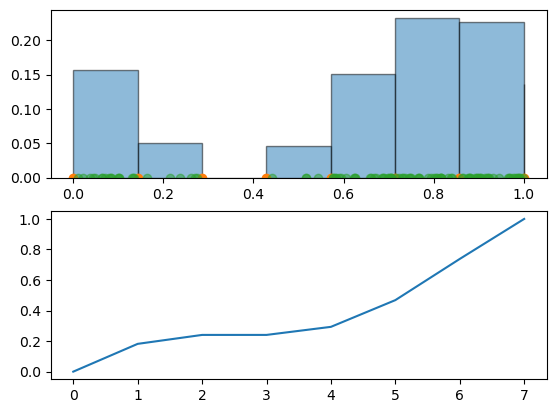

In [2555]:
look_at = 4 #0
zc = z_vals_coarse[look_at,0,:,0]
zf = z_vals_fine[look_at,0,:,0]
wc = weights_coarse[look_at,0,:,0]
wf = weights_fine[look_at,0,:,0]
width_coarse = w_coarse[look_at,0,:,0]
width_fine = w_fine[look_at,0,:,0]

fig, ax = p.subplots(2,1)
ax[0].bar(zc+width_coarse/2, wc, width = width_coarse, 
   label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax[0].scatter(zc,  tf.zeros_like(wc))

n_resample = 100
wc = tf.pad(wc[:,None], [[1,0], [0,0]] )[:-1,0]
print(wc)
wc_cdf = tf.math.cumsum(wc/tf.math.reduce_sum(wc))
# print("wc_cdf: \n", wc_cdf.numpy())
randy = tf.sort(tf.random.uniform([n_resample]))
# print("randy: \n ", randy.numpy())
idx = tf.searchsorted(wc_cdf, randy, side='right')
# print("idx: \n", idx.numpy())

cdf_left = tf.gather(wc_cdf, idx - 1)
# print("cdf_left:\n", cdf_left.numpy())
cdf_right = tf.gather(wc_cdf, idx)
values_left = tf.gather(zc, idx - 1)
# print("values_left:\n", values_left.numpy())
values_right = tf.gather(zc, idx)

weights = (randy - cdf_left) / (cdf_right - cdf_left)
continuous_samples = values_left + weights * (values_right - values_left)
# print(continuous_samples)

ax[1].plot(wc_cdf)
ax[0].scatter(continuous_samples, tf.zeros_like(continuous_samples), alpha = 0.5)

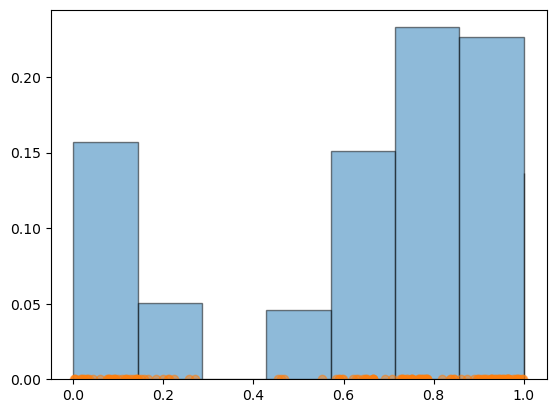

In [2565]:
#updated to run in parallel about two batch dimensions
def resample_z_vals(z_vals_coarse, z_vals_fine, weights_coarse, weights_fine, w_coarse, w_fine, n_resample=128):
    zc = z_vals_coarse[:,:,:,0]
    zf = z_vals_fine[:,:,:,0]
    wc = weights_coarse[:,:,:,0]
    wf = weights_fine[:,:,:,0]
    width_coarse = w_coarse[:,:,:,0]
    width_fine = w_fine[:,:,:,0]

    # Pad weights for CDF computation, removing the first padded value after
    wc_padded = tf.pad(wc, [[0, 0], [0, 0], [1, 0]], constant_values=0)[:, :, :-1]

    # Compute the cumulative sum (CDF) across the last axis
    wc_cdf = tf.math.cumsum(wc_padded / tf.math.reduce_sum(wc_padded, axis=-1, keepdims=True), axis=-1)

    # Generate uniform random samples, sorting to ensure they're in CDF order
    randy = tf.sort(tf.random.uniform([H, W, n_resample]), axis=-1)

    # Find the indices in the CDF where the random samples should be inserted
    idx = tf.searchsorted(wc_cdf, randy, side='right')

    # Gather CDF and z-values for left and right indices
    cdf_left = tf.gather(wc_cdf, idx - 1, batch_dims=2)
    cdf_right = tf.gather(wc_cdf, idx, batch_dims=2)
    values_left = tf.gather(zc, idx - 1, batch_dims=2)
    values_right = tf.gather(zc, idx, batch_dims=2)

    # Interpolate to get the continuous sample values
    weights = (randy - cdf_left) / (cdf_right - cdf_left)
    z_vals_new = values_left + weights * (values_right - values_left)

    return z_vals_new

continuous_samples = resample_z_vals(z_vals_coarse, z_vals_fine, weights_coarse, weights_fine, w_coarse, w_fine)

fig, ax = p.subplots()
look_at = 4
ax.bar(z_vals_coarse[look_at,0,:,0]+w_coarse[look_at,0,:,0]/2, weights_coarse[look_at,0,:,0], 
       width = w_coarse[look_at,0,:,0], label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax.scatter(continuous_samples[look_at,0,:], tf.zeros_like(continuous_samples[look_at,0,:]), alpha = 0.5)

# TODO:  
1. expand z_vals to correct dimensions
2. get widths_fine with TF
3. Make dummy coarse data
4. get loss function working in parallel with TF
5. do inverse sampling from coarse network

* get inverse sampling working efficiently in parallel
* put in training loop

In [1827]:
test = tf.constant([[[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]], [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]], [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]]])
print(np.shape(test))

(3, 2, 3)


In [1867]:
def foo(inputs):
    x, y = inputs
    out = tf.math.reduce_sum(x) + y
    return out

# Define a function that processes each element using foo
def map_fn(index):
    return foo((d[index[0], index[1]], y[index[0], index[1]]))

a = tf.constant([[1, 2, 3, 1], [1, 2, 3, 0]])
b = tf.constant([[4, 5, 6, 1], [1, 2, 8, 1]])
c = tf.constant([[7, 8, 9, 1], [1, 2, 3, 1]])
d = tf.stack([a, b, c])
y = tf.constant([[1, 1], [1, 1], [1, 1]])  # Shape (3, 2)

# Create indices to map over
indices = tf.stack(tf.meshgrid(tf.range(d.shape[0]), tf.range(d.shape[1]), indexing='ij'), axis=-1)
indices = tf.reshape(indices, (-1, 2))

# Use tf.map_fn to apply the function over indices
results = tf.map_fn(map_fn, indices, fn_output_signature=tf.int32)
results = tf.reshape(results, (d.shape[0], d.shape[1]))

# Test outputs
print(results)
print(results[2, 1])
print(foo((d[2, 1], y[2, 1])))

tf.Tensor(
[[ 8  7]
 [17 13]
 [26  8]], shape=(3, 2), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
